In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


# I. Import Packages

In [2]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


✨🍰✨ Everything looks OK!
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-94pj51cg
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-94pj51cg
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 51a3e1c0cb728b5012ed2dd0d0ba1452bb311e39
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-dqp2sy8k/elegantrl_c3f9cb1c5ffe45be98d3a6c4a2ff459e
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-dqp2sy8k/elegantrl_c3f9cb1c5ffe45be98d3a6c4a2ff459e
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 155f07fcfe2d0f0a0318f820e8e2f2401ff30eca
  Preparing metadata (setup.py) ... done


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from stable_baselines3.common.logger import configure

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


## Local

In [4]:
# import sys
# import itertools
# import pandas as pd
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# # matplotlib.use('Agg')
# import datetime
# sys.path.append('D:\\Learning\\University\\UIT\\AI\\Projects\\AI4Finance\\FinRL')

# %matplotlib inline
# from finrl.config_tickers import DOW_30_TICKER
# from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
# from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
# from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
# from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
# from stable_baselines3.common.logger import configure

# from pprint import pprint

# import itertools

In [5]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [6]:
TRAIN_START_DATE = '2015-10-19'
TRAIN_END_DATE = '2023-04-10'
TRADE_START_DATE = '2023-04-10'
TRADE_END_DATE = '2024-05-31'

In [7]:
df = YahooDownloader(start_date=TRAIN_START_DATE,
                    end_date= TRADE_END_DATE,
                    ticker_list = DOW_30_TICKER ).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (64181, 8)


In [8]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2015-10-19,27.700001,27.937500,27.527500,25.254646,119036800,AAPL,0
1,2015-10-19,152.610001,156.139999,152.460007,119.657593,3271700,AMGN,0
2,2015-10-19,76.949997,77.309998,76.730003,67.789581,4054900,AXP,0
3,2015-10-19,137.600006,138.610001,136.389999,123.376869,4022000,BA,0
4,2015-10-19,69.250000,69.470001,68.800003,54.845356,5712000,CAT,0


In [9]:
df.tail()

,date,open,high,low,close,volume,tic,day
64176,2024-05-30,482.320007,486.029999,478.000000,481.649994,5170500,UNH,3
64177,2024-05-30,268.700012,271.640015,268.309998,271.299988,4903100,V,3
64178,2024-05-30,39.220001,40.360001,39.180000,40.330002,19636500,VZ,3
64179,2024-05-30,14.920000,15.560000,14.880000,15.390000,12134300,WBA,3
64180,2024-05-30,64.930000,65.169998,64.769997,64.889999,13053500,WMT,3


In [10]:
df.shape

(64181, 8)

In [11]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2015-10-19,27.700001,27.937500,27.527500,25.254646,119036800,AAPL,0
1,2015-10-19,152.610001,156.139999,152.460007,119.657593,3271700,AMGN,0
2,2015-10-19,76.949997,77.309998,76.730003,67.789581,4054900,AXP,0
3,2015-10-19,137.600006,138.610001,136.389999,123.376869,4022000,BA,0
4,2015-10-19,69.250000,69.470001,68.800003,54.845356,5712000,CAT,0


In [12]:
print(f"Unique stock: {len(df['tic'].unique())}")

Unique stock: 30


In [13]:
df['tic'].value_counts()

tic
AAPL    2168
AMGN    2168
WMT     2168
WBA     2168
VZ      2168
V       2168
UNH     2168
TRV     2168
PG      2168
NKE     2168
MSFT    2168
MRK     2168
MMM     2168
MCD     2168
KO      2168
JPM     2168
JNJ     2168
INTC    2168
IBM     2168
HON     2168
HD      2168
GS      2168
DIS     2168
CVX     2168
CSCO    2168
CRM     2168
CAT     2168
BA      2168
AXP     2168
DOW     1309
Name: count, dtype: int64

In [14]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

In [15]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

[*********************100%%**********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (2167, 8)
Successfully added vix


Successfully added turbulence index


In [16]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [17]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2015-10-19,AAPL,27.700001,27.937500,27.527500,25.254646,119036800.0,0.0,0.0,100.0,66.666667,100.0,14.98,0.0
1,2015-10-19,AMGN,152.610001,156.139999,152.460007,119.657593,3271700.0,0.0,0.0,100.0,66.666667,100.0,14.98,0.0
2,2015-10-19,AXP,76.949997,77.309998,76.730003,67.789581,4054900.0,0.0,0.0,100.0,66.666667,100.0,14.98,0.0
3,2015-10-19,BA,137.600006,138.610001,136.389999,123.376869,4022000.0,0.0,0.0,100.0,66.666667,100.0,14.98,0.0
4,2015-10-19,CAT,69.250000,69.470001,68.800003,54.845356,5712000.0,0.0,0.0,100.0,66.666667,100.0,14.98,0.0
5,2015-10-19,CRM,78.440002,79.330002,77.480003,77.828339,4346900.0,0.0,0.0,100.0,66.666667,100.0,14.98,0.0
6,2015-10-19,CSCO,28.120001,28.290001,27.940001,21.635242,20778100.0,0.0,0.0,100.0,66.666667,100.0,14.98,0.0
7,2015-10-19,CVX,90.360001,90.540001,89.220001,61.977409,8900400.0,0.0,0.0,100.0,66.666667,100.0,14.98,0.0
8,2015-10-19,DIS,108.250000,109.970001,107.940002,102.287529,8001900.0,0.0,0.0,100.0,66.666667,100.0,14.98,0.0
9,2015-10-19,GS,183.479996,186.500000,183.149994,155.611221,2665700.0,0.0,0.0,100.0,66.666667,100.0,14.98,0.0


In [18]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2015-10-19 to 2023-04-10

Trading data period: 2023-04-10 to 2024-05-31


In [19]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

54520
8323


In [20]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
1879,2023-04-06,UNH,511.000000,514.239990,507.149994,505.012634,3472600.0,3.0,5.541498,58.540604,279.097059,35.184354,18.4,14.379545
1879,2023-04-06,V,226.160004,226.729996,224.679993,223.816345,4285200.0,3.0,1.520162,54.576656,103.912298,3.859382,18.4,14.379545
1879,2023-04-06,VZ,39.500000,39.779999,39.160000,36.750206,21546600.0,3.0,0.326123,57.386778,142.521195,30.356990,18.4,14.379545
1879,2023-04-06,WBA,36.060001,36.200001,35.560001,32.981426,5632100.0,3.0,0.190837,52.470096,99.399804,20.287198,18.4,14.379545
1879,2023-04-06,WMT,49.599998,50.346668,49.506668,49.374760,17891700.0,3.0,0.748976,61.516897,188.195337,51.910016,18.4,14.379545


In [21]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2023-04-10,AAPL,161.419998,162.029999,160.080002,160.951416,47716900.0,0.0,3.540676,58.313187,70.807134,19.905225,18.969999,13.478034
0,2023-04-10,AMGN,256.440002,256.440002,250.050003,241.024231,1595600.0,0.0,3.532640,55.182108,196.606744,35.022705,18.969999,13.478034
0,2023-04-10,AXP,158.039993,161.169998,157.800003,158.924774,2372600.0,0.0,-1.819187,48.283205,-62.396368,13.899838,18.969999,13.478034
0,2023-04-10,BA,211.000000,214.100006,209.729996,210.779999,3729300.0,0.0,1.725616,54.056877,82.397598,16.567093,18.969999,13.478034
0,2023-04-10,CAT,210.220001,216.089996,209.320007,210.467651,3839000.0,0.0,-5.426833,42.938579,-87.868384,23.500835,18.969999,13.478034


In [22]:
INDICATORS = ['macd', 'rsi_30', 'cci_30', 'dx_30']

In [23]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [24]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [25]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, A2C. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [26]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

### Agent Training: 3 algorithms (A2C, DDPG, PPO)


### Agent 1: A2C


In [27]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


In [28]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

---------------------------------------
| time/                 |             |
|    fps                | 113         |
|    iterations         | 100         |
|    time_elapsed       | 4           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.2       |
|    explained_variance | 0.112       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 53          |
|    reward             | 0.055829026 |
|    std                | 1           |
|    value_loss         | 1.77        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 119       |
|    iterations         | 200       |
|    time_elapsed       | 8         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | -0.441    |
|    learning_rate

In [29]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

### Agent 2: DDPG

In [30]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/ddpg


In [31]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 1879, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 2311710.97
total_reward: 1311710.97
total_cost: 1183.95
total_trades: 33829
Sharpe: 0.687
-------------------------------------
| time/              |              |
|    episodes        | 4            |
|    fps             | 70           |
|    time_elapsed    | 106          |
|    total_timesteps | 7520         |
| train/             |              |
|    actor_loss      | -8.72        |
|    critic_loss     | 943          |
|    learning_rate   | 0.001        |
|    n_updates       | 7419         |
|    reward          | -0.088885635 |
-------------------------------------
-------------------------------------
| time/              |              |
|    episodes        | 8            |
|    fps             | 70           |
|    time_elapsed    | 213          |
|    total_timesteps | 15040        |
| train/             |              |
|    actor_loss      | -11.2        |
|    critic_loss     | 29.5         |
|   

In [32]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

### Agent 3: PPO

In [33]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to results/ppo


In [34]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

----------------------------------
| time/              |           |
|    fps             | 128       |
|    iterations      | 1         |
|    time_elapsed    | 15        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.8751922 |
----------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 123        |
|    iterations           | 2          |
|    time_elapsed         | 33         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01616091 |
|    clip_fraction        | 0.203      |
|    clip_range           | 0.2        |
|    entropy_loss         | -41.2      |
|    explained_variance   | -0.00209   |
|    learning_rate        | 0.00025    |
|    loss                 | 9.16       |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0359    |
|    reward               | 0

In [35]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_ppo else None

In [36]:
rebalance_window = 63
validation_window = 63
ensemble_agent = DRLEnsembleAgent(
    df=processed_full,
    train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
    val_test_period=(TRADE_START_DATE,TRADE_END_DATE),
    rebalance_window=rebalance_window,
    validation_window=validation_window,
    stock_dim=stock_dimension,
    hmax=100,
    initial_amount=1000000,
    buy_cost_pct=0.001,
    sell_cost_pct=0.001,
    reward_scaling=1e-4,
    state_space=state_space,
    action_space=stock_dimension,
    tech_indicator_list=INDICATORS,
    print_verbosity=5
)

In [37]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000
                 }

In [38]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 None,
                                                None,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  238.09053821817488
======Model training from:  2015-10-19 to  2023-04-11
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_4


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


--------------------------------------
| time/                 |            |
|    fps                | 125        |
|    iterations         | 100        |
|    time_elapsed       | 3          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.1      |
|    explained_variance | 0.125      |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -53.8      |
|    reward             | -0.2414222 |
|    std                | 0.999      |
|    value_loss         | 2.18       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 103       |
|    iterations         | 200       |
|    time_elapsed       | 9         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


---------------------------------------
| time/                 |             |
|    fps                | 112         |
|    iterations         | 100         |
|    time_elapsed       | 4           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.1       |
|    explained_variance | -1.87       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 27.6        |
|    reward             | -0.48890314 |
|    std                | 0.998       |
|    value_loss         | 1.56        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 104       |
|    iterations         | 200       |
|    time_elapsed       | 9         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | -0.132    |
|    learning_rate

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


---------------------------------------
| time/                 |             |
|    fps                | 102         |
|    iterations         | 100         |
|    time_elapsed       | 4           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | -4.91       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 1.76        |
|    reward             | -0.20208506 |
|    std                | 1.01        |
|    value_loss         | 0.2         |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 110       |
|    iterations         | 200       |
|    time_elapsed       | 9         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | -0.376    |
|    learning_rate

In [39]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2023-04-11,2023-07-12,DDPG,0.116612,0.091675,0.20633,None,None
1,189,2023-07-12,2023-10-10,A2C,0.020495,-0.302161,-0.041057,None,None
2,252,2023-10-10,2024-01-10,DDPG,0.388834,0.430866,0.528248,None,None


## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [40]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [41]:
insample_risk_indicator.vix.describe()

count    1880.000000
mean       19.064660
std         8.000082
min         9.140000
25%        13.272500
50%        17.330000
75%        22.685000
max        82.690002
Name: vix, dtype: float64

In [42]:
insample_risk_indicator.vix.quantile(0.996)

62.773519424438305

In [43]:
insample_risk_indicator.turbulence.describe()

count    1880.000000
mean       34.844637
std        49.915046
min         0.000000
25%        13.156548
50%        23.033371
75%        39.533120
max       652.621516
Name: turbulence, dtype: float64

In [44]:
insample_risk_indicator.turbulence.quantile(0.996)

403.9704915802717

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [45]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [46]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2023-04-10,AAPL,161.419998,162.029999,160.080002,160.951416,47716900.0,0.0,3.540676,58.313187,70.807134,19.905225,18.969999,13.478034
0,2023-04-10,AMGN,256.440002,256.440002,250.050003,241.024231,1595600.0,0.0,3.532640,55.182108,196.606744,35.022705,18.969999,13.478034
0,2023-04-10,AXP,158.039993,161.169998,157.800003,158.924774,2372600.0,0.0,-1.819187,48.283205,-62.396368,13.899838,18.969999,13.478034
0,2023-04-10,BA,211.000000,214.100006,209.729996,210.779999,3729300.0,0.0,1.725616,54.056877,82.397598,16.567093,18.969999,13.478034
0,2023-04-10,CAT,210.220001,216.089996,209.320007,210.467651,3839000.0,0.0,-5.426833,42.938579,-87.868384,23.500835,18.969999,13.478034


In [47]:
train_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_trade_gym)

hit end!


In [48]:
train_model = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_trade_gym)

hit end!


In [49]:
train_model = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_trade_gym)

hit end!


In [50]:
df_account_value_a2c.shape

(287, 2)

<a id='7'></a>
# Part 6.5: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [51]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

### Helper functions for mean returns and variance-covariance matrix

In [52]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

### Calculate the weights for mean-variance

In [53]:
train_mvo = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE).reset_index()

In [54]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[160.95141602, 241.02423096, 158.92477417, ...,  36.62919617,
         33.27639389,  49.27980423],
       [159.729599  , 241.53335571, 159.60528564, ...,  36.72228241,
         33.4699707 ,  49.13574219],
       [159.0342865 , 239.67933655, 157.10021973, ...,  36.48957062,
         32.8984642 ,  48.8967247 ],
       ...,
       [189.97999573, 305.83999634, 238.17999268, ...,  39.74000168,
         16.03000069,  65.37999725],
       [189.99000549, 300.19000244, 237.25      , ...,  39.36000061,
         15.38000011,  65.04000092],
       [190.28999329, 296.36999512, 235.94000244, ...,  39.09999847,
         14.89000034,  64.91999817]])

In [55]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [ 0.117  0.05   0.066  0.066  0.089  0.073  0.058  0.07   0.015  0.055
  0.068  0.058  0.026  0.033  0.045  0.066  0.041  0.072  0.007  0.066
  0.119  0.054  0.056  0.047  0.097  0.074  0.019 -0.018  0.068]
Variance-Covariance matrix of returns
 [[3.589 1.247 1.75  2.15  1.489 2.385 1.798 1.357 1.569 1.808 1.641 1.438
  1.255 2.279 0.857 1.557 0.891 1.097 1.275 0.827 2.437 1.756 0.933 1.049
  1.426 1.891 0.588 1.239 0.873]
 [1.247 2.391 1.092 0.989 1.142 1.118 1.172 0.965 0.87  1.155 1.04  0.997
  0.996 1.348 0.992 1.143 0.72  0.74  0.982 1.143 1.264 0.892 0.835 0.909
  1.257 1.117 0.656 1.149 0.721]
 [1.75  1.092 4.363 3.522 2.284 1.841 1.733 2.421 2.274 2.81  1.683 2.153
  1.734 1.974 0.931 2.882 1.242 1.417 1.608 0.924 1.767 1.942 0.869 1.897
  1.708 2.309 0.77  1.6   0.625]
 [2.15  0.989 3.522 7.524 2.738 2.208 1.85  2.893 2.586 2.978 1.982 2.609
  1.965 2.481 0.953 2.968 1.429 1.635 1.742 0.923 1.989 2.291 0.893 2.06
  1.735 2.311 0.845 1.8

### Use PyPortfolioOpt

In [56]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([171720.,      0.,      0.,      0.,  66780.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,  72510.,      0.,  64020., 281200.,
            0.,      0.,      0., 190070.,      0.,      0.,      0.,
       153700.])

In [57]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1049.865,    0.   ,    0.   ,    0.   ,  326.941,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,  262.1  ,
          0.   ,  585.52 ,  974.003,    0.   ,    0.   ,    0.   ,
        376.367,    0.   ,    0.   ,    0.   , 3112.927])

In [58]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2023-04-10,9.981271e+05
2023-04-11,9.939455e+05
2023-04-12,9.940859e+05
2023-04-13,1.010307e+06
2023-04-14,1.000458e+06
...,...
2024-05-22,1.281876e+06
2024-05-23,1.267475e+06
2024-05-24,1.270751e+06
2024-05-28,1.264186e+06


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [59]:
unique_trade_date = processed[(processed.date > TEST_START_DATE) & (processed.date <= TEST_END_DATE)].date.unique()

In [60]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
df_account_value.to_csv('df_account_value.csv')

Sharpe Ratio:  0.1572923977839163


In [61]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

# print("df_result_ensemble.columns: ", df_result_ensemble.columns)
# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
# print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
# print("df_result_ensemble: ", df_result_ensemble)

df_account_value_a2c.to_csv("df_account_value_a2c.csv")
df_account_value_ddpg.to_csv("df_account_value_ddpg.csv")
df_account_value_ppo.to_csv("df_account_value_ppo.csv")
df_result_ensemble.to_csv("df_result_ensemble.csv")

#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.DataFrame()
result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_dji, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result.columns = ['a2c', 'ddpg', 'ppo', 'dji']
# result.columns = ['mean var', 'dji', 'ensemble']
result.columns = ['a2c', 'ddpg', 'ppo', 'mean var', 'dji', 'ensemble']
print(result.head())

# print("result: ", result)
result.to_csv("result.csv")

==============Get Baseline Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (288, 8)


Annual return          0.116939
Cumulative returns     0.134726
Annual volatility      0.101389
Sharpe ratio           1.145290
Calmar ratio           1.296763
Stability              0.774610
Max drawdown          -0.090178
Omega ratio            1.203156
Sortino ratio          1.726596
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.092319
Daily value at risk   -0.012313
dtype: float64
                     a2c          ddpg           ppo      mean var  \
date                                                                 
2023-07-12  1.056270e+06  1.016928e+06  1.054119e+06  1.070030e+06   
2023-07-13  1.058523e+06  1.018111e+06  1.058164e+06  1.073675e+06   
2023-07-14  1.060586e+06  1.026161e+06  1.055961e+06  1.089369e+06   
2023-07-17  1.065437e+06  1.029567e+06  1.062201e+06  1.094447e+06   
2023-07-18  1.078919e+06  1.044220e+06  1.072695e+06  1.115146e+06   

                     dji      ensemble  
date                                 

In [62]:
# df_result_ddpg

<Figure size 1500x500 with 0 Axes>

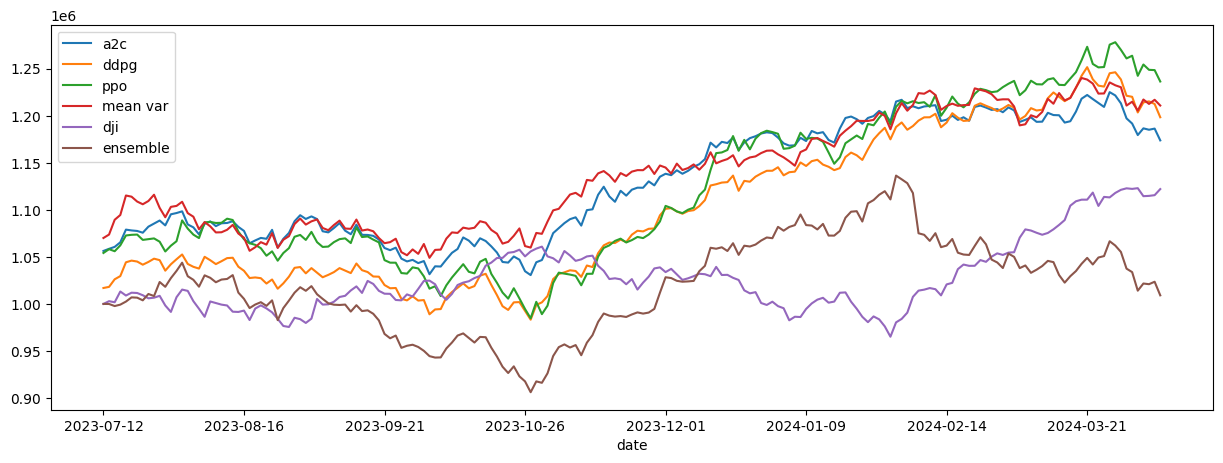

In [63]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();